In [1]:
import utils, data, simulation
import os
import os.path as op
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
checkAxon = True
drawAllDist = False

In [3]:
#where the data is
datapath = os.environ['VISCOG_DATA']
#folder containing scripts
scriptpath = os.environ['SCRIPT_DATA']
outpath = op.join(scriptpath, 'data')
filename = 'S_12-005_12-104_13-101__collated_both_sessions.csv'


(double_x2, catch, subjectdata) = data.get_two_point(outpath, scriptpath, filename)

In [4]:
simulations = simulation.get_sims(subjectdata)
subjects = subjectdata.index

In [5]:
subjectdata

,implant_rot,implant_type,implant_type_str,implant_x,implant_y,loc_od_x,loc_od_y,viscog_subject_id,xmax,xmin,ymax,ymin,eye,session,rho,lambda,scale
subject_id,,,,,,,,,,,,,,,,,
12-005,-0.49500,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-1331.0000,-850.0000,16.200000,1.380000,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_29,315.00,500.0,0.5
12-104,-0.35500,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-515.0000,108.0000,18.500000,2.620000,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_30,1887.69,10.0,0.5
13-101,-0.67358,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-965.1227,429.0195,15.055678,1.821214,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_31,1127.00,717.0,0.5


## Figure 5


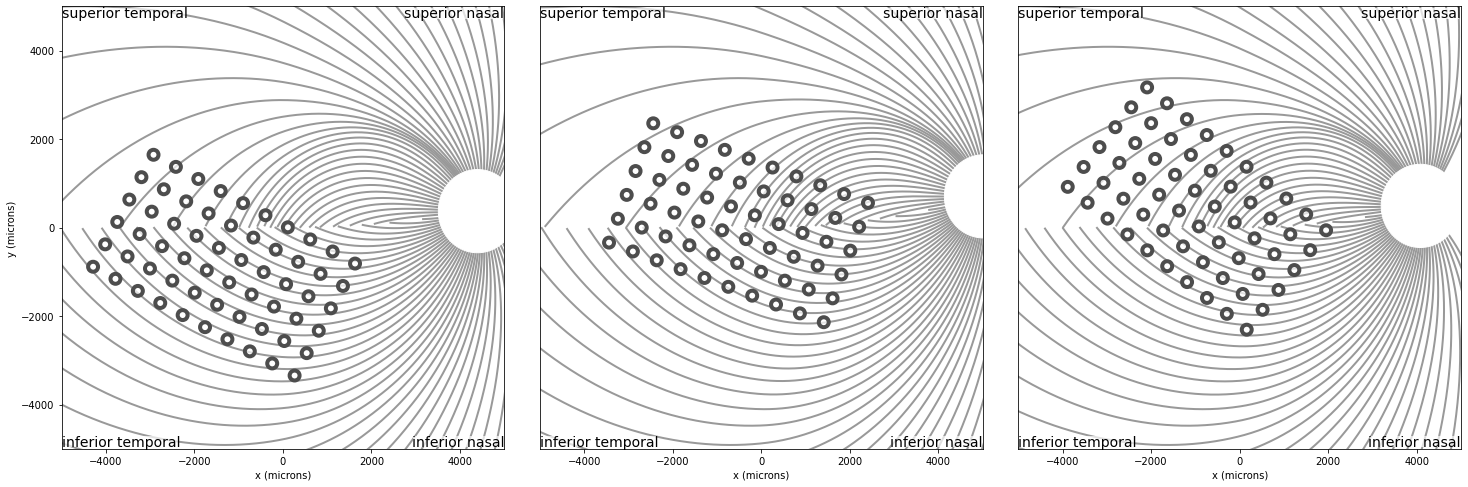

In [6]:
from pulse2percept import viz as viz
plt.rcParams.update({'font.sans-serif':'Helvetica'})
xlim = (-5000,5000)
ylim = (-5000,5000)
fig, ax = plt.subplots(1,3, figsize = (20,12))
fig.tight_layout(pad=0.5)
i = 0 
for subject in subjects:
    viz.plot_implant_on_axon_map(simulations.loc[subject, 'implant'], 
                                 loc_od =(subjectdata.loc[subject, 'loc_od_x'],subjectdata.loc[subject, 'loc_od_y']),
                                 ax= ax[i], xlim= xlim, ylim= ylim)
    ax[i].set_title('')
    if i>0:
        ax[i].set_ylabel('')
        ax[i].axes.yaxis.set_visible(False)
    i+=1
    
plt.savefig(op.join(outpath,'figures', 'implants.svg'), format='svg', bbox_inches = 'tight', pad_inches=1)
plt.savefig(op.join(outpath,'figures', 'implants.tif'), format='tif', bbox_inches = 'tight', pad_inches=1)


## Figure 6

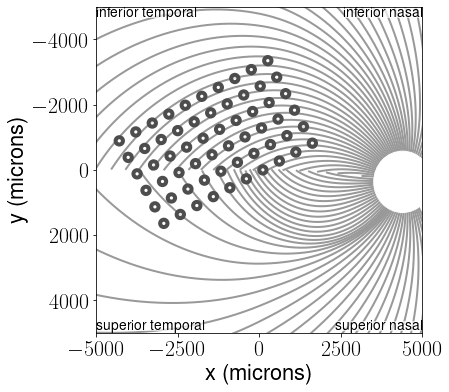

In [7]:
from pulse2percept import viz as viz
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size'   : 22})
rc('text', usetex=True)
fig, ax = plt.subplots(1,1, figsize = (8,6))

subject= '12-005'
viz.plot_implant_on_axon_map( simulations.loc[subject, 'implant'], upside_down=True, xlim=[-5000,5000], ylim=[-5000,5000],
                                 loc_od =(subjectdata.loc[subject, 'loc_od_x'],subjectdata.loc[subject, 'loc_od_y']),
                                 ax= ax,     annotate_implant=False,
                                annotate_quadrants=True)
ax.set_title('')
plt.savefig(op.join(outpath,'figures', 'implant_ud.png'), format='png')

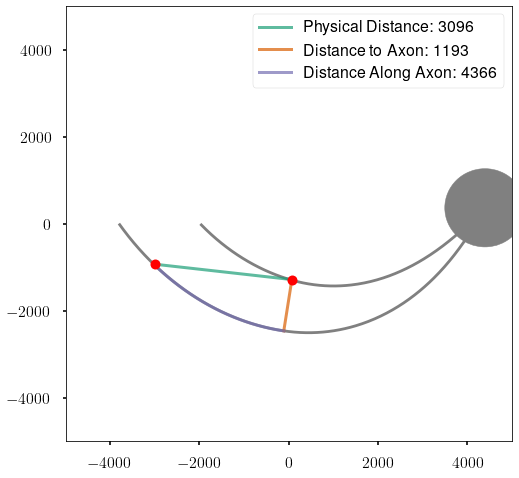

In [8]:
plt.style.use(['seaborn-poster'])
row = double_x2.loc[37]
bi_dists = utils.get_axonal_distances(row, 'bidirectonal', simulations= simulations)

cmap = plt.get_cmap('Dark2')
fig, ax = plt.subplots(1,1, figsize=(8, 8))

utils.plot_distances(np.transpose(bi_dists), ax)
plt.savefig(op.join(outpath,'figures', 'distances_ud.png'), format='png')

/mnt/home/yucel/p2p/lib/python3.8/site-packages/pulse2percept/percepts/base.py:165: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, np.flipud(frame), cmap=cmap, vmin=vmin,


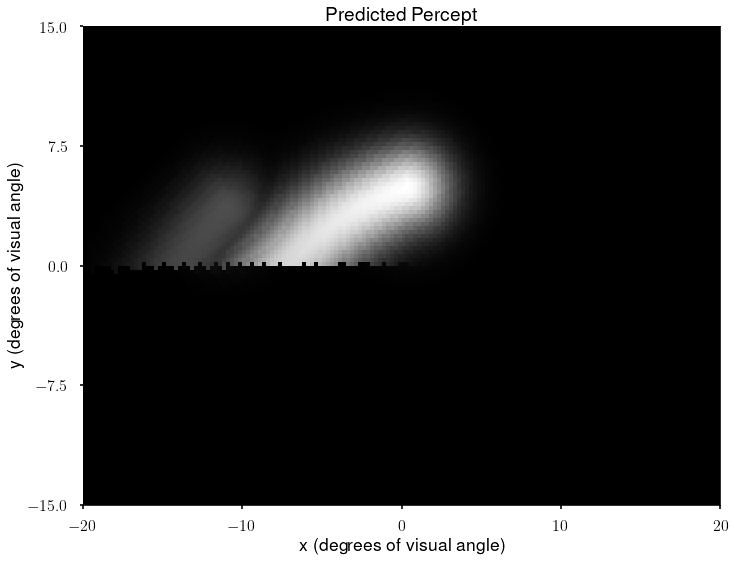

In [17]:
model =  simulations.loc[row['subject_id'],'axonmap']
argus = simulations.loc[row['subject_id'],'implant']

argus.stim = {row['pts_electrode1']: row['pts_amp1'], row['pts_electrode2']:row['pts_amp2']}
model.set_params({'rho':500})
percept= model.predict_percept(argus)
ax = percept.plot()
ax.set_title('Predicted Percept')
plt.savefig(op.join(outpath,'figures', 'percept.png'), format='png')

## Median Split Data

In [10]:
def get_mean_amp(row):
    return np.mean([int(row['pts_amp1']),int(row['pts_amp2'])])
double_x2['mean_amplitude'] = double_x2. apply(get_mean_amp, axis =1)
# 1 if they report 2 shapes, 0 if they report anything else    
double_x2['prob_2'] =double_x2.apply(utils.convert_prob, axis=1)

In [12]:
double_x2['electrode_pair'] = double_x2.apply(utils.combine_electrodes, axis=1)
double_x2['electrode_distance'] = double_x2.apply(utils.get_distance, simulations = simulations, axis=1)

In [13]:
if checkAxon:
    axonal_calc_bi = double_x2.apply(utils.get_axonal_distances, model_type = 'bidirectional',simulations = simulations, axis =1)
    double_x2[['dta_bi', 'daa_bi']] = axonal_calc_bi[['distance_to_axon', 'distance_along_axon']]

In [14]:
def median_split(data, median_var):

    # divides dataset through the median

    # of a variable of interest,

    # returns two DataFrames (smaller than median, larger than median)

    data = data.sort_values(by= median_var)

    median = data[median_var].median()

    return data[data[median_var]<=median], data[data[median_var]>median]


   

subject_id=="12-005"
subject_id=="12-104"
subject_id=="13-101"


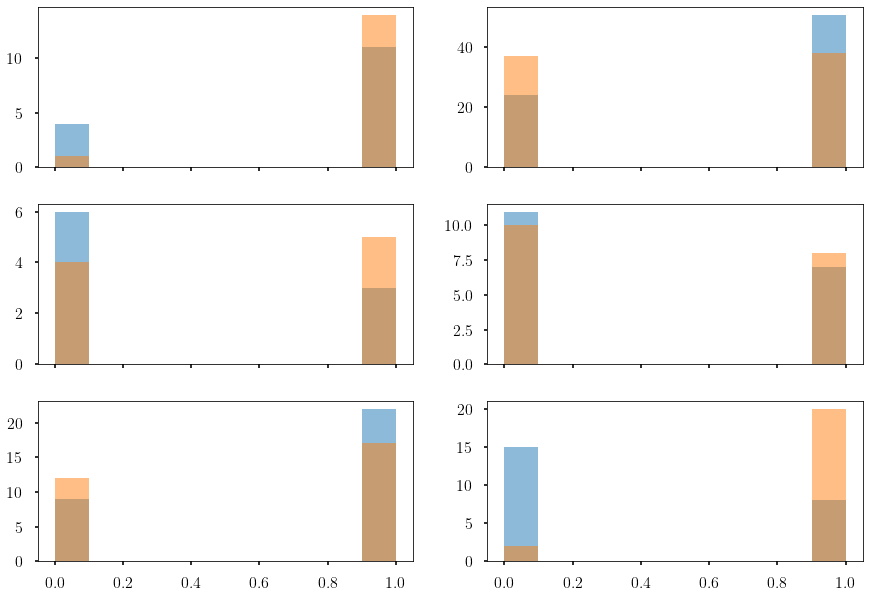

In [15]:
from statsmodels.stats.proportion import proportion_confint as confint
splits_val = pd.DataFrame()
i = 0
j= 0 
method = 'wilson'

fig,ax = plt.subplots(3,2, sharex=True)
fig.tight_layout(pad=1 )

for subject in subjects:
    j = 0
    query_string = 'subject_id==' + '"' + subject + '"'
    print(query_string)  
    #select subject
    split = double_x2.query(query_string)
    #split their data into sessions
    split_sessions =  [x for _, x in split.groupby(split['date'])]
    #for each session 
    for session in split_sessions:
        #do a median split
        low, high = median_split(session,'index')
        
        
        #calculate prob of seeing 2 i.e. mean of col prob 2
        splits_val = splits_val.append( {'subject_id': subject,'session': j, 'half': 1, 'prob_2': np.mean(low['prob_2']),
                                 'std_dev' : np.std(low['prob_2'], ddof= 1), 
                                 'std_err': np.std(low['prob_2'], ddof= 1)/  np.sqrt(np.size(low['prob_2'])), 
                                '95ci': np.round(confint(np.sum(low['prob_2']), len(low['prob_2']), method= method),2)}, 
                                 ignore_index= True)
        splits_val =splits_val.append( {'subject_id': subject,'session': j, 'half': 2, 'prob_2': np.mean(high['prob_2']), 
                                'std_dev' : np.std(high['prob_2'], ddof= 1), 
                                'std_err': np.std(high['prob_2'], ddof= 1)/  np.sqrt(np.size(high['prob_2'])),
                                  '95ci': np.round(confint(np.sum(high['prob_2']), len(high['prob_2']), method= method),2)}, 
                                  ignore_index= True)


        lplot = ax[i,j].hist(low['prob_2'], alpha=0.5, label = 'First Half')
        hplot = ax[i,j].hist(high['prob_2'], alpha=0.5, label = 'Second Half')        
        j += 1 
    i += 1 


In [16]:
#calculated confidence intervals for split sessions
# table 2
splits_val

,95ci,half,prob_2,session,std_dev,std_err,subject_id
0,"[0.48, 0.89]",1.0,0.733333,0.0,0.457738,0.118187,12-005
1,"[0.7, 0.99]",2.0,0.933333,0.0,0.258199,0.066667,12-005
2,"[0.57, 0.77]",1.0,0.680000,1.0,0.469617,0.054227,12-005
3,"[0.4, 0.62]",2.0,0.506667,1.0,0.503322,0.058119,12-005
4,"[0.12, 0.65]",1.0,0.333333,0.0,0.500000,0.166667,12-104
5,"[0.27, 0.81]",2.0,0.555556,0.0,0.527046,0.175682,12-104
6,"[0.2, 0.61]",1.0,0.388889,1.0,0.501631,0.118236,12-104
7,"[0.25, 0.66]",2.0,0.444444,1.0,0.511310,0.120517,12-104
8,"[0.53, 0.84]",1.0,0.709677,0.0,0.461414,0.082872,13-101
9,"[0.41, 0.74]",2.0,0.586207,0.0,0.501230,0.093076,13-101


## Distance Correlations


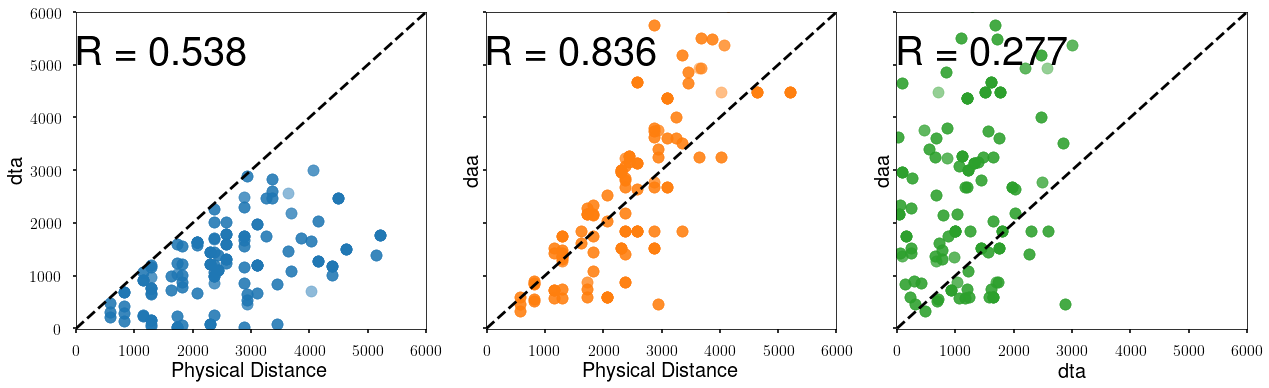

In [28]:

labelsize=20
## import matplotlib.pyplot as plt
%matplotlib inline 
cmap = plt.get_cmap('tab10')
col = cmap.colors[2]

fig,axes = plt.subplots(1,3, figsize=(18,6), sharex= True, sharey=True)
fig.tight_layout(pad=4)

axes[0].plot([0,6000],[0,6000],'k--')
axes[1].plot([0,6000],[0,6000],'k--')
axes[2].plot([0,6000],[0,6000],'k--')

#axes[0].plot([xval,yval],[xval,yval],'k--')
#axes[1].plot([xval,yval],[xval,yval],'k--')
#axes[2].plot([xval,yval],[xval,yval],'k--')


axes[0].scatter(double_x2['electrode_distance'], double_x2['dta_bi'], c = cmap.colors[0], alpha=0.5)

axes[0].set_xlabel('Physical Distance ', size=labelsize)
axes[0].set_ylabel('dta ', size=labelsize)
axes[0].set_xlim([-10,6000])
axes[0].set_ylim([-10,6000])

axes[1].scatter(double_x2['electrode_distance'], double_x2['daa_bi'], c = cmap.colors[1],alpha=0.5)
axes[1].set_xlabel('Physical Distance ', size=labelsize)
axes[1].set_ylabel('daa', size=labelsize)

axes[2].scatter(double_x2['dta_bi'], double_x2['daa_bi'],alpha=0.5,c = cmap.colors[2] )
axes[2].set_xlabel('dta', size=labelsize)

axes[2].set_ylabel('daa', size=labelsize)

axes[0].annotate('R = %4.3f' %np.corrcoef((double_x2['electrode_distance'], double_x2['dta_bi']))[0,1], (10,5000), size =40)
axes[1].annotate('R = %4.3f' %np.corrcoef((double_x2['electrode_distance'], double_x2['daa_bi']))[0,1], (10,5000), size =40)
axes[2].annotate('R = %4.3f' %np.corrcoef((double_x2['daa_bi']), (double_x2['dta_bi']))[0,1], (10,5000), size =40)
plt.savefig(op.join(outpath,'figures', 'inset_corr.png'), format='png')